In [7]:
from __future__ import print_function
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import csv

In [8]:
# load the measured input intensity data from the indicated file path
input_intensity_file_path = r"C:\Users\zxq220007\Box\Quantum Optics Lab\TeTON OANN Testbed\Data 2024\May 22 2024\Input intensity\input_intensity_boxes.txt"
# read the file and store the second element of each row in a numpy array
# skip the first row
input_intensity = np.loadtxt(input_intensity_file_path, delimiter=',', usecols=1, skiprows=1)
# convert the numpy array to a torch tensor
Distr = torch.tensor(input_intensity, dtype=torch.float32)


# Reading the parameters from the csv file
csv_file_path = r"C:\Users\zxq220007\Box\Quantum Optics Lab\TeTON OANN Testbed\Anderson Xu\AONN\Neural Network Training\Optimized_Curve_Fitting_Parameters.csv"

# Indicating the concavity of the non linear funtion used for curve fitting
# 1: Concave up exponential function
# 2: Concave down exponential function
function_tpye = 1

# Initializing the arrays to store the parameters
a = np.array([])
OD = np.array([])
g = np.array([])

# Reading the csv file
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    # we want to skip the first row in the csv file
    next(csv_reader)  

    for row in csv_reader:
        a = np.append(a, float(row[1]))
        OD = np.append(OD, float(row[2]))
        g = np.append(g, float(row[3]))

# Provided parameter values
# a = np.array([3534100, 3722200, 3852400, 4307000, 3657400, 3141500, 3178200,
#           3960700, 3765900, 4158300, 3463600, 3263600, 4042800, 3859800,
#           3263500, 3321000, 4023600, 3909900, 4442100, 3975800])

# OD = np.array([2.6724, 2.6481, 2.7274, 3.0563, 3.3325, 2.9912, 2.8601, 3.3032,
#           2.6161, 2.5694, 3.2993, 3.3299, 2.4537, 2.3774, 2.42, 2.9881,
#           2.7565, 3.007, 3.1546, 3.063])

# g = np.array([23.072, 25.567, 29.146, 24.402, 27.776, 41.254, 24.124, 20.662,
#           33.321, 25.71, 28.885, 36.446, 26.033, 23.523, 40.512, 38.207,
#           39.111, 29.031, 32.155, 27.549])


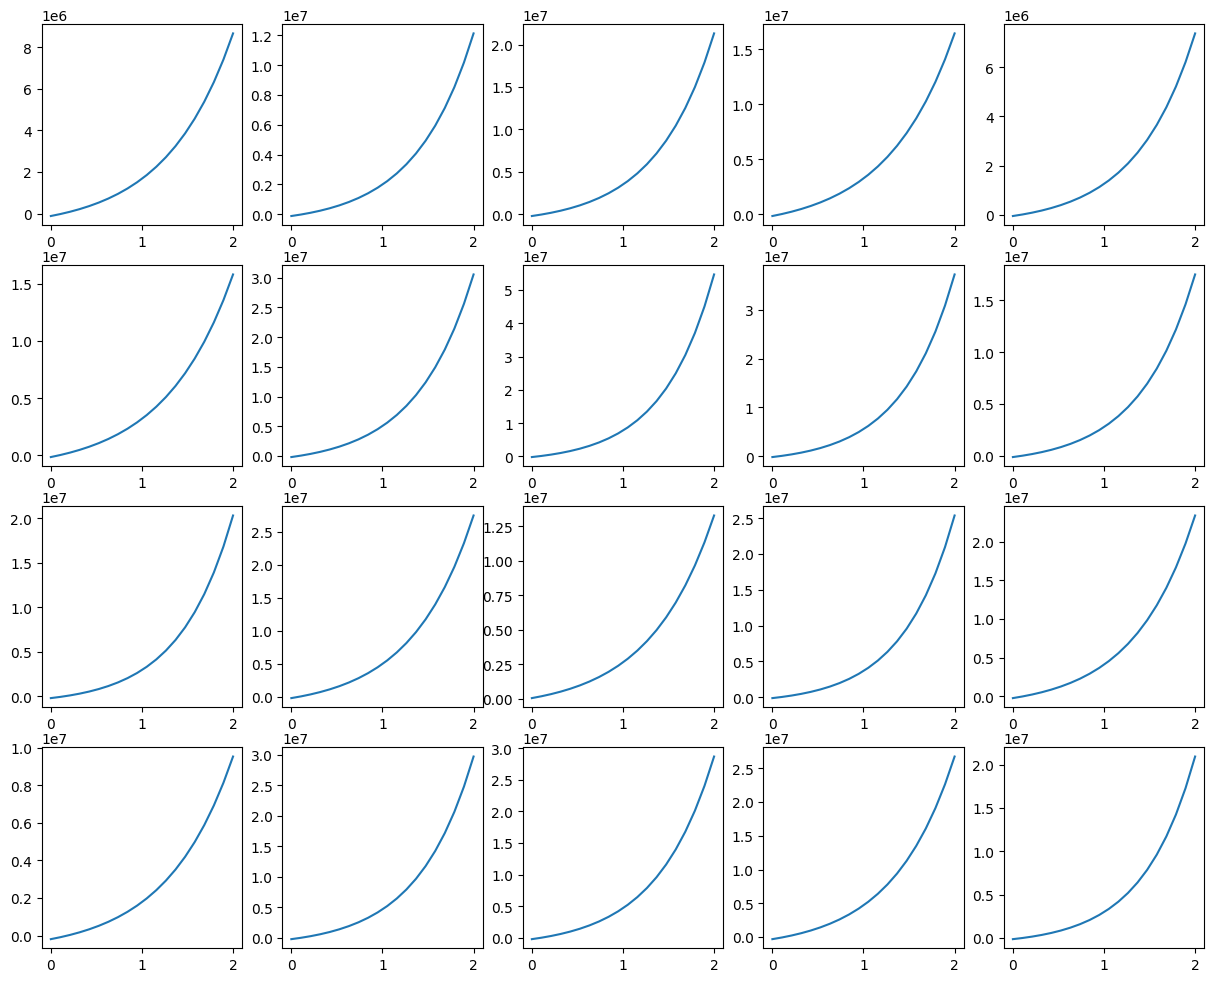

In [9]:
# create an array of x values from 0 to 100
x = np.linspace(0, 2, 20)
fig, axs = plt.subplots(4, 5, figsize=(15, 12))
axs = axs.ravel()

for i in range(20):
    y = a[i] * np.exp(OD[i] * x) + g[i]
    axs[i].plot(x, y)

C:\Users\zxq220007\AppData\Local\Temp\ipykernel_35072\2777880448.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Distr = torch.tensor(Distr, dtype=torch.float32)


Epoch 1: loss:0.020057
Epoch 1: Accuracy: 6417 / 10000 (64%)

Epoch 2: loss:0.012441
Epoch 2: Accuracy: 7266 / 10000 (73%)

Epoch 3: loss:0.011155
Epoch 3: Accuracy: 7475 / 10000 (75%)

Epoch 4: loss:0.010546
Epoch 4: Accuracy: 7555 / 10000 (76%)

Epoch 5: loss:0.010146
Epoch 5: Accuracy: 7599 / 10000 (76%)

Epoch 6: loss:0.009837
Epoch 6: Accuracy: 7683 / 10000 (77%)

Epoch 7: loss:0.009621
Epoch 7: Accuracy: 7665 / 10000 (77%)

Epoch 8: loss:0.009394
Epoch 8: Accuracy: 7701 / 10000 (77%)

Epoch 9: loss:0.009262
Epoch 9: Accuracy: 7870 / 10000 (79%)

Epoch 10: loss:0.009101
Epoch 10: Accuracy: 7908 / 10000 (79%)

Epoch 11: loss:0.009001
Epoch 11: Accuracy: 7834 / 10000 (78%)

Epoch 12: loss:0.008884
Epoch 12: Accuracy: 7912 / 10000 (79%)

Epoch 13: loss:0.008809
Epoch 13: Accuracy: 7865 / 10000 (79%)

Epoch 14: loss:0.008734
Epoch 14: Accuracy: 7952 / 10000 (80%)

Epoch 15: loss:0.008644
Epoch 15: Accuracy: 7988 / 10000 (80%)

Epoch 16: loss:0.008600
Epoch 16: Accuracy: 7755 / 10000 (

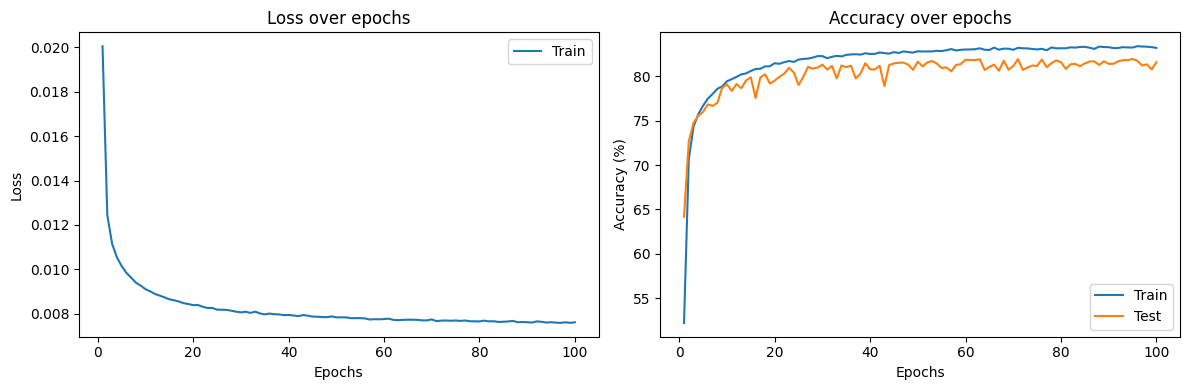

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # initializing all parameters for the nonlinear layer and the linear layers 
        self.fc1 = nn.Parameter(torch.rand(25, 144) / 400000)
        self.fc2 = nn.Parameter(torch.rand(10, 25) / 200)

        self.a = torch.tensor(a, dtype=torch.float32)
        self.gamma12 = torch.tensor(g, dtype=torch.float32)
        self.OD = torch.tensor(OD, dtype=torch.float32)
        self.Distr = torch.tensor(Distr, dtype=torch.float32)

    def forward(self, x, R):
        # adding the input intensity to the data
        x = x.view(-1, 144)
        # x = x * self.Distr.view(-1, 144)
        # first linear layer
        x = F.linear(x, abs(self.fc1))

        # nonlinear layer using data from Ying
        # x = self.a * torch.exp(-12 * self.OD * self.gamma12 / (x * 12800 + self.gamma12 * 12))
        # x = self.a *torch.exp(self.OD * x) + self.gamma12
        # x = F.linear(x, abs(self.fc3))

        # adding randomness to the last linear 
        rand4 = 1 + torch.randn(10) * R
        out = F.linear(x, abs(self.fc2)) * rand4
        return out

# def confusion_matrix(preds, labels):
#     # calculating the confusion matrix
#     conf_matrix = torch.zeros(10, 10)
#     for p, t in zip(preds, labels):
#         conf_matrix[p, t] += 1
#     return conf_matrix
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    training_loss = 0
    training_accuracy = 0
    correct = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, 0.5)
        loss = F.nll_loss(F.log_softmax(output, dim=1), target)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    training_loss /= len(train_loader.dataset)
    training_accuracy = 100. * correct / len(train_loader.dataset)
    
    print('Epoch {}: loss:{:.6f}'.format(epoch, training_loss))

    return training_loss, training_accuracy

def test(model, device, test_loader, epoch):
    model.eval()
    # test_loss = 0
    correct = 0
    errors = np.array([])
    # ConfuMatrix = torch.zeros(10, 10)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, 0.5)
            pred = output.max(1, keepdim=True)[1]
            output2 = output / torch.sum(output, dim=1).view(-1, 1)
            A1 = output2[[np.arange(target.shape[0]), target]]
            output2[[np.arange(target.shape[0]), target]] = 0
            pred2 = output2.max(1, keepdim=True)[1]
            A2 = output2[[np.arange(pred2.shape[0]), pred2.view(-1)]]
            errors = np.append(errors, (A1 / A2 - 1).cpu().detach().numpy())
            correct += pred.eq(target.view_as(pred)).sum().item()
            # ConfuMatrix += confusion_matrix(pred, target)
    print('Epoch {}: Accuracy: {} / {} ({:.0f}%)\n'.format(epoch, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

    return (100. * correct / len(test_loader.dataset))

def save_weights_to_excel(weights, filename):
    df = pd.DataFrame(abs(weights.cpu().detach().numpy()))
    df.to_excel(filename, index=False)
    
def main():
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                       ])),
        batch_size=64, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                       ])),
        batch_size=1000, shuffle=True)

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00)

    # Create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

    for epoch in range(1, 50 + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
        test_accuracy = test(model, device, test_loader, epoch)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        test_accuracies.append(test_accuracy) 

        # Step the scheduler
        # scheduler.step()
    
    # print(train_losses)

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 51), train_losses, label='Train')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, 51), train_accuracies, label='Train')
    plt.plot(range(1, 51), test_accuracies, label='Test')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

    # Save the weight matrices as Excel files
    save_weights_to_excel(model.fc1.data, r"C:\Users\zxq220007\Box\Quantum Optics Lab\TeTON OANN Testbed\Anderson Xu\AONN\Neural Network Training\fc1_weights.xlsx")
    save_weights_to_excel(model.fc2.data, r"C:\Users\zxq220007\Box\Quantum Optics Lab\TeTON OANN Testbed\Anderson Xu\AONN\Neural Network Training\fc2_weights.xlsx")

if __name__ == '__main__':
    main()